# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [8]:
batch_size = 60       # Batch size 600-> 60
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs =100            #1000 -> 100

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [9]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [10]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 18)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 18) --> (batch, 16, 36)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 36) --> (batch, 8, 36)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Build the inception layer:

![title](img/HAR_inception.png)

In [11]:
with graph.as_default():
    
    # convolution: input to output of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_11 = tf.layers.conv1d(inputs=max_pool_4, filters=36, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_21 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_31 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # average pool: input to middle layer of inception
    # (batch, 8, 36) --> (batch, 8, 36)
    avg_pool_41 = tf.layers.average_pooling1d(inputs=max_pool_4, pool_size=2, strides=1, padding='same')
    
    ## Middle layer of inception
    
    # convolution: middle to out layer of inception (size=2)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv2_22 = tf.layers.conv1d(inputs=conv1_21, filters=36, kernel_size=2, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=4)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv4_32 = tf.layers.conv1d(inputs=conv1_31, filters=36, kernel_size=4, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_42 = tf.layers.conv1d(inputs=avg_pool_41, filters=36, kernel_size=1, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    ## Out layer: Concatenate filters
    # (batch, 8, 4*36)
    inception_out = tf.concat([conv1_11, conv2_22, conv4_32, conv1_42], axis=2)

Now, flatten and pass to the classifier

In [12]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(inception_out, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [13]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [15]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/100 Iteration: 5 Train loss: 1.911708 Train acc: 0.133333
Epoch: 0/100 Iteration: 10 Train loss: 1.803115 Train acc: 0.266667
Epoch: 0/100 Iteration: 10 Validation loss: 1.774216 Validation acc: 0.278889
Epoch: 0/100 Iteration: 15 Train loss: 1.787667 Train acc: 0.183333
Epoch: 0/100 Iteration: 20 Train loss: 1.723648 Train acc: 0.250000
Epoch: 0/100 Iteration: 20 Validation loss: 1.730071 Validation acc: 0.337222
Epoch: 0/100 Iteration: 25 Train loss: 1.795967 Train acc: 0.216667
Epoch: 0/100 Iteration: 30 Train loss: 1.724592 Train acc: 0.216667
Epoch: 0/100 Iteration: 30 Validation loss: 1.691437 Validation acc: 0.344444
Epoch: 0/100 Iteration: 35 Train loss: 1.754667 Train acc: 0.200000
Epoch: 0/100 Iteration: 40 Train loss: 1.649312 Train acc: 0.316667
Epoch: 0/100 Iteration: 40 Validation loss: 1.656035 Validation acc: 0.342778
Epoch: 0/100 Iteration: 45 Train loss: 1.635518 Train acc: 0.266667
Epoch: 0/100 Iteration: 50 Train loss: 1.565452 Train acc: 0.383333
Epoch: 0/

Epoch: 4/100 Iteration: 390 Validation loss: 0.558969 Validation acc: 0.848333
Epoch: 4/100 Iteration: 395 Train loss: 0.590951 Train acc: 0.800000
Epoch: 4/100 Iteration: 400 Train loss: 0.504462 Train acc: 0.833333
Epoch: 4/100 Iteration: 400 Validation loss: 0.536695 Validation acc: 0.847222
Epoch: 4/100 Iteration: 405 Train loss: 0.680552 Train acc: 0.700000
Epoch: 4/100 Iteration: 410 Train loss: 0.605930 Train acc: 0.650000
Epoch: 4/100 Iteration: 410 Validation loss: 0.515431 Validation acc: 0.856667
Epoch: 4/100 Iteration: 415 Train loss: 0.616672 Train acc: 0.733333
Epoch: 4/100 Iteration: 420 Train loss: 0.544431 Train acc: 0.783333
Epoch: 4/100 Iteration: 420 Validation loss: 0.495486 Validation acc: 0.862222
Epoch: 4/100 Iteration: 425 Train loss: 0.561459 Train acc: 0.766667
Epoch: 4/100 Iteration: 430 Train loss: 0.591523 Train acc: 0.750000
Epoch: 4/100 Iteration: 430 Validation loss: 0.480195 Validation acc: 0.861111
Epoch: 4/100 Iteration: 435 Train loss: 0.618022 Trai

Epoch: 8/100 Iteration: 780 Validation loss: 0.202074 Validation acc: 0.921111
Epoch: 8/100 Iteration: 785 Train loss: 0.257572 Train acc: 0.916667
Epoch: 8/100 Iteration: 790 Train loss: 0.189564 Train acc: 0.933333
Epoch: 8/100 Iteration: 790 Validation loss: 0.200197 Validation acc: 0.923889
Epoch: 8/100 Iteration: 795 Train loss: 0.206797 Train acc: 0.900000
Epoch: 8/100 Iteration: 800 Train loss: 0.216246 Train acc: 0.933333
Epoch: 8/100 Iteration: 800 Validation loss: 0.195403 Validation acc: 0.923889
Epoch: 8/100 Iteration: 805 Train loss: 0.183910 Train acc: 0.916667
Epoch: 8/100 Iteration: 810 Train loss: 0.267427 Train acc: 0.916667
Epoch: 8/100 Iteration: 810 Validation loss: 0.195243 Validation acc: 0.922222
Epoch: 8/100 Iteration: 815 Train loss: 0.159057 Train acc: 0.933333
Epoch: 9/100 Iteration: 820 Train loss: 0.268362 Train acc: 0.900000
Epoch: 9/100 Iteration: 820 Validation loss: 0.189975 Validation acc: 0.924444
Epoch: 9/100 Iteration: 825 Train loss: 0.176478 Trai

Epoch: 12/100 Iteration: 1180 Validation loss: 0.139411 Validation acc: 0.936111
Epoch: 13/100 Iteration: 1185 Train loss: 0.177437 Train acc: 0.916667
Epoch: 13/100 Iteration: 1190 Train loss: 0.068265 Train acc: 0.966667
Epoch: 13/100 Iteration: 1190 Validation loss: 0.138881 Validation acc: 0.938889
Epoch: 13/100 Iteration: 1195 Train loss: 0.102429 Train acc: 0.983333
Epoch: 13/100 Iteration: 1200 Train loss: 0.140704 Train acc: 0.933333
Epoch: 13/100 Iteration: 1200 Validation loss: 0.138072 Validation acc: 0.942222
Epoch: 13/100 Iteration: 1205 Train loss: 0.204435 Train acc: 0.883333
Epoch: 13/100 Iteration: 1210 Train loss: 0.212140 Train acc: 0.933333
Epoch: 13/100 Iteration: 1210 Validation loss: 0.138977 Validation acc: 0.944445
Epoch: 13/100 Iteration: 1215 Train loss: 0.097537 Train acc: 0.983333
Epoch: 13/100 Iteration: 1220 Train loss: 0.218820 Train acc: 0.883333
Epoch: 13/100 Iteration: 1220 Validation loss: 0.138256 Validation acc: 0.944445
Epoch: 13/100 Iteration: 12

Epoch: 17/100 Iteration: 1580 Validation loss: 0.123094 Validation acc: 0.949444
Epoch: 17/100 Iteration: 1585 Train loss: 0.219775 Train acc: 0.883333
Epoch: 17/100 Iteration: 1590 Train loss: 0.179741 Train acc: 0.916667
Epoch: 17/100 Iteration: 1590 Validation loss: 0.122519 Validation acc: 0.949444
Epoch: 17/100 Iteration: 1595 Train loss: 0.172041 Train acc: 0.966667
Epoch: 17/100 Iteration: 1600 Train loss: 0.106921 Train acc: 0.933333
Epoch: 17/100 Iteration: 1600 Validation loss: 0.121806 Validation acc: 0.949444
Epoch: 17/100 Iteration: 1605 Train loss: 0.125548 Train acc: 0.950000
Epoch: 17/100 Iteration: 1610 Train loss: 0.232194 Train acc: 0.916667
Epoch: 17/100 Iteration: 1610 Validation loss: 0.120860 Validation acc: 0.947778
Epoch: 17/100 Iteration: 1615 Train loss: 0.256450 Train acc: 0.900000
Epoch: 17/100 Iteration: 1620 Train loss: 0.058467 Train acc: 0.966667
Epoch: 17/100 Iteration: 1620 Validation loss: 0.120375 Validation acc: 0.950000
Epoch: 17/100 Iteration: 16

Epoch: 21/100 Iteration: 1965 Train loss: 0.042841 Train acc: 0.983333
Epoch: 21/100 Iteration: 1970 Train loss: 0.106384 Train acc: 0.950000
Epoch: 21/100 Iteration: 1970 Validation loss: 0.112915 Validation acc: 0.951111
Epoch: 21/100 Iteration: 1975 Train loss: 0.152087 Train acc: 0.966667
Epoch: 21/100 Iteration: 1980 Train loss: 0.109637 Train acc: 0.966667
Epoch: 21/100 Iteration: 1980 Validation loss: 0.112981 Validation acc: 0.950000
Epoch: 21/100 Iteration: 1985 Train loss: 0.164086 Train acc: 0.916667
Epoch: 21/100 Iteration: 1990 Train loss: 0.068465 Train acc: 0.983333
Epoch: 21/100 Iteration: 1990 Validation loss: 0.112395 Validation acc: 0.951111
Epoch: 21/100 Iteration: 1995 Train loss: 0.070000 Train acc: 0.966667
Epoch: 21/100 Iteration: 2000 Train loss: 0.105246 Train acc: 0.950000
Epoch: 21/100 Iteration: 2000 Validation loss: 0.113277 Validation acc: 0.951111
Epoch: 22/100 Iteration: 2005 Train loss: 0.111388 Train acc: 0.966667
Epoch: 22/100 Iteration: 2010 Train l

Epoch: 25/100 Iteration: 2360 Validation loss: 0.108288 Validation acc: 0.951667
Epoch: 25/100 Iteration: 2365 Train loss: 0.183717 Train acc: 0.900000
Epoch: 26/100 Iteration: 2370 Train loss: 0.117109 Train acc: 0.966667
Epoch: 26/100 Iteration: 2370 Validation loss: 0.108107 Validation acc: 0.951111
Epoch: 26/100 Iteration: 2375 Train loss: 0.097505 Train acc: 0.966667
Epoch: 26/100 Iteration: 2380 Train loss: 0.063735 Train acc: 0.983333
Epoch: 26/100 Iteration: 2380 Validation loss: 0.107470 Validation acc: 0.951111
Epoch: 26/100 Iteration: 2385 Train loss: 0.133150 Train acc: 0.950000
Epoch: 26/100 Iteration: 2390 Train loss: 0.071011 Train acc: 0.983333
Epoch: 26/100 Iteration: 2390 Validation loss: 0.107695 Validation acc: 0.952222
Epoch: 26/100 Iteration: 2395 Train loss: 0.070162 Train acc: 0.983333
Epoch: 26/100 Iteration: 2400 Train loss: 0.208951 Train acc: 0.900000
Epoch: 26/100 Iteration: 2400 Validation loss: 0.107559 Validation acc: 0.953334
Epoch: 26/100 Iteration: 24

Epoch: 30/100 Iteration: 2760 Validation loss: 0.104609 Validation acc: 0.955556
Epoch: 30/100 Iteration: 2765 Train loss: 0.097033 Train acc: 0.933333
Epoch: 30/100 Iteration: 2770 Train loss: 0.173041 Train acc: 0.933333
Epoch: 30/100 Iteration: 2770 Validation loss: 0.104862 Validation acc: 0.955000
Epoch: 30/100 Iteration: 2775 Train loss: 0.139837 Train acc: 0.966667
Epoch: 30/100 Iteration: 2780 Train loss: 0.058433 Train acc: 0.966667
Epoch: 30/100 Iteration: 2780 Validation loss: 0.105507 Validation acc: 0.952222
Epoch: 30/100 Iteration: 2785 Train loss: 0.099117 Train acc: 0.950000
Epoch: 30/100 Iteration: 2790 Train loss: 0.091926 Train acc: 0.950000
Epoch: 30/100 Iteration: 2790 Validation loss: 0.105084 Validation acc: 0.951667
Epoch: 30/100 Iteration: 2795 Train loss: 0.107998 Train acc: 0.966667
Epoch: 30/100 Iteration: 2800 Train loss: 0.084621 Train acc: 0.966667
Epoch: 30/100 Iteration: 2800 Validation loss: 0.104543 Validation acc: 0.951111
Epoch: 30/100 Iteration: 28

Epoch: 34/100 Iteration: 3160 Validation loss: 0.102312 Validation acc: 0.952222
Epoch: 34/100 Iteration: 3165 Train loss: 0.100067 Train acc: 0.950000
Epoch: 34/100 Iteration: 3170 Train loss: 0.062701 Train acc: 0.966667
Epoch: 34/100 Iteration: 3170 Validation loss: 0.101211 Validation acc: 0.952778
Epoch: 34/100 Iteration: 3175 Train loss: 0.138440 Train acc: 0.933333
Epoch: 34/100 Iteration: 3180 Train loss: 0.110417 Train acc: 0.950000
Epoch: 34/100 Iteration: 3180 Validation loss: 0.101525 Validation acc: 0.952778
Epoch: 34/100 Iteration: 3185 Train loss: 0.089585 Train acc: 0.966667
Epoch: 35/100 Iteration: 3190 Train loss: 0.054993 Train acc: 0.966667
Epoch: 35/100 Iteration: 3190 Validation loss: 0.105778 Validation acc: 0.951667
Epoch: 35/100 Iteration: 3195 Train loss: 0.074759 Train acc: 0.966667
Epoch: 35/100 Iteration: 3200 Train loss: 0.160869 Train acc: 0.933333
Epoch: 35/100 Iteration: 3200 Validation loss: 0.102597 Validation acc: 0.952222
Epoch: 35/100 Iteration: 32

Epoch: 39/100 Iteration: 3555 Train loss: 0.080503 Train acc: 0.950000
Epoch: 39/100 Iteration: 3560 Train loss: 0.113248 Train acc: 0.966667
Epoch: 39/100 Iteration: 3560 Validation loss: 0.100350 Validation acc: 0.952778
Epoch: 39/100 Iteration: 3565 Train loss: 0.100478 Train acc: 0.966667
Epoch: 39/100 Iteration: 3570 Train loss: 0.053867 Train acc: 0.966667
Epoch: 39/100 Iteration: 3570 Validation loss: 0.099361 Validation acc: 0.955000
Epoch: 39/100 Iteration: 3575 Train loss: 0.195087 Train acc: 0.916667
Epoch: 39/100 Iteration: 3580 Train loss: 0.112915 Train acc: 0.950000
Epoch: 39/100 Iteration: 3580 Validation loss: 0.099951 Validation acc: 0.955556
Epoch: 39/100 Iteration: 3585 Train loss: 0.117480 Train acc: 0.916667
Epoch: 39/100 Iteration: 3590 Train loss: 0.122337 Train acc: 0.950000
Epoch: 39/100 Iteration: 3590 Validation loss: 0.100022 Validation acc: 0.954445
Epoch: 39/100 Iteration: 3595 Train loss: 0.104024 Train acc: 0.916667
Epoch: 39/100 Iteration: 3600 Train l

Epoch: 43/100 Iteration: 3940 Validation loss: 0.098339 Validation acc: 0.955000
Epoch: 43/100 Iteration: 3945 Train loss: 0.099226 Train acc: 0.966667
Epoch: 43/100 Iteration: 3950 Train loss: 0.096791 Train acc: 0.933333
Epoch: 43/100 Iteration: 3950 Validation loss: 0.098174 Validation acc: 0.955000
Epoch: 43/100 Iteration: 3955 Train loss: 0.077888 Train acc: 0.966667
Epoch: 43/100 Iteration: 3960 Train loss: 0.121378 Train acc: 0.933333
Epoch: 43/100 Iteration: 3960 Validation loss: 0.097756 Validation acc: 0.955000
Epoch: 43/100 Iteration: 3965 Train loss: 0.092386 Train acc: 0.950000
Epoch: 43/100 Iteration: 3970 Train loss: 0.114831 Train acc: 0.950000
Epoch: 43/100 Iteration: 3970 Validation loss: 0.097858 Validation acc: 0.952222
Epoch: 43/100 Iteration: 3975 Train loss: 0.045017 Train acc: 0.983333
Epoch: 43/100 Iteration: 3980 Train loss: 0.054014 Train acc: 0.983333
Epoch: 43/100 Iteration: 3980 Validation loss: 0.097269 Validation acc: 0.955556
Epoch: 43/100 Iteration: 39

Epoch: 47/100 Iteration: 4320 Validation loss: 0.097322 Validation acc: 0.955556
Epoch: 47/100 Iteration: 4325 Train loss: 0.123395 Train acc: 0.966667
Epoch: 47/100 Iteration: 4330 Train loss: 0.098241 Train acc: 0.933333
Epoch: 47/100 Iteration: 4330 Validation loss: 0.096605 Validation acc: 0.955000
Epoch: 47/100 Iteration: 4335 Train loss: 0.103125 Train acc: 0.950000
Epoch: 47/100 Iteration: 4340 Train loss: 0.184547 Train acc: 0.900000
Epoch: 47/100 Iteration: 4340 Validation loss: 0.095401 Validation acc: 0.955000
Epoch: 47/100 Iteration: 4345 Train loss: 0.206727 Train acc: 0.916667
Epoch: 47/100 Iteration: 4350 Train loss: 0.023503 Train acc: 1.000000
Epoch: 47/100 Iteration: 4350 Validation loss: 0.095682 Validation acc: 0.954445
Epoch: 47/100 Iteration: 4355 Train loss: 0.074224 Train acc: 0.966667
Epoch: 47/100 Iteration: 4360 Train loss: 0.106463 Train acc: 0.966667
Epoch: 47/100 Iteration: 4360 Validation loss: 0.095149 Validation acc: 0.953889
Epoch: 47/100 Iteration: 43

Epoch: 51/100 Iteration: 4710 Validation loss: 0.094379 Validation acc: 0.956111
Epoch: 51/100 Iteration: 4715 Train loss: 0.132985 Train acc: 0.933333
Epoch: 51/100 Iteration: 4720 Train loss: 0.065865 Train acc: 0.950000
Epoch: 51/100 Iteration: 4720 Validation loss: 0.093511 Validation acc: 0.956111
Epoch: 51/100 Iteration: 4725 Train loss: 0.047830 Train acc: 0.983333
Epoch: 51/100 Iteration: 4730 Train loss: 0.084711 Train acc: 0.966667
Epoch: 51/100 Iteration: 4730 Validation loss: 0.094064 Validation acc: 0.955556
Epoch: 52/100 Iteration: 4735 Train loss: 0.087921 Train acc: 0.950000
Epoch: 52/100 Iteration: 4740 Train loss: 0.114872 Train acc: 0.950000
Epoch: 52/100 Iteration: 4740 Validation loss: 0.095398 Validation acc: 0.955000
Epoch: 52/100 Iteration: 4745 Train loss: 0.035816 Train acc: 0.983333
Epoch: 52/100 Iteration: 4750 Train loss: 0.096434 Train acc: 0.950000
Epoch: 52/100 Iteration: 4750 Validation loss: 0.093742 Validation acc: 0.956111
Epoch: 52/100 Iteration: 47

Epoch: 55/100 Iteration: 5080 Validation loss: 0.091609 Validation acc: 0.958333
Epoch: 55/100 Iteration: 5085 Train loss: 0.086870 Train acc: 0.966667
Epoch: 55/100 Iteration: 5090 Train loss: 0.074952 Train acc: 0.983333
Epoch: 55/100 Iteration: 5090 Validation loss: 0.091726 Validation acc: 0.957778
Epoch: 55/100 Iteration: 5095 Train loss: 0.147744 Train acc: 0.916667
Epoch: 56/100 Iteration: 5100 Train loss: 0.104881 Train acc: 0.966667
Epoch: 56/100 Iteration: 5100 Validation loss: 0.092510 Validation acc: 0.957778
Epoch: 56/100 Iteration: 5105 Train loss: 0.062692 Train acc: 0.966667
Epoch: 56/100 Iteration: 5110 Train loss: 0.051428 Train acc: 0.983333
Epoch: 56/100 Iteration: 5110 Validation loss: 0.092395 Validation acc: 0.956667
Epoch: 56/100 Iteration: 5115 Train loss: 0.131516 Train acc: 0.933333
Epoch: 56/100 Iteration: 5120 Train loss: 0.050588 Train acc: 0.983333
Epoch: 56/100 Iteration: 5120 Validation loss: 0.091697 Validation acc: 0.957222
Epoch: 56/100 Iteration: 51

Epoch: 59/100 Iteration: 5460 Validation loss: 0.090507 Validation acc: 0.958889
Epoch: 60/100 Iteration: 5465 Train loss: 0.041868 Train acc: 0.983333
Epoch: 60/100 Iteration: 5470 Train loss: 0.066558 Train acc: 0.950000
Epoch: 60/100 Iteration: 5470 Validation loss: 0.091355 Validation acc: 0.959445
Epoch: 60/100 Iteration: 5475 Train loss: 0.148830 Train acc: 0.933333
Epoch: 60/100 Iteration: 5480 Train loss: 0.043023 Train acc: 0.983333
Epoch: 60/100 Iteration: 5480 Validation loss: 0.090303 Validation acc: 0.958333
Epoch: 60/100 Iteration: 5485 Train loss: 0.113447 Train acc: 0.950000
Epoch: 60/100 Iteration: 5490 Train loss: 0.166210 Train acc: 0.933333
Epoch: 60/100 Iteration: 5490 Validation loss: 0.090956 Validation acc: 0.960000
Epoch: 60/100 Iteration: 5495 Train loss: 0.069751 Train acc: 0.966667
Epoch: 60/100 Iteration: 5500 Train loss: 0.128534 Train acc: 0.933333
Epoch: 60/100 Iteration: 5500 Validation loss: 0.090180 Validation acc: 0.959445
Epoch: 60/100 Iteration: 55

Epoch: 64/100 Iteration: 5860 Validation loss: 0.086848 Validation acc: 0.960556
Epoch: 64/100 Iteration: 5865 Train loss: 0.101729 Train acc: 0.966667
Epoch: 64/100 Iteration: 5870 Train loss: 0.109912 Train acc: 0.933333
Epoch: 64/100 Iteration: 5870 Validation loss: 0.086636 Validation acc: 0.960000
Epoch: 64/100 Iteration: 5875 Train loss: 0.043984 Train acc: 0.983333
Epoch: 64/100 Iteration: 5880 Train loss: 0.072560 Train acc: 0.966667
Epoch: 64/100 Iteration: 5880 Validation loss: 0.086932 Validation acc: 0.960000
Epoch: 64/100 Iteration: 5885 Train loss: 0.046030 Train acc: 1.000000
Epoch: 64/100 Iteration: 5890 Train loss: 0.029177 Train acc: 1.000000
Epoch: 64/100 Iteration: 5890 Validation loss: 0.086847 Validation acc: 0.961667
Epoch: 64/100 Iteration: 5895 Train loss: 0.073131 Train acc: 0.966667
Epoch: 64/100 Iteration: 5900 Train loss: 0.038452 Train acc: 0.983333
Epoch: 64/100 Iteration: 5900 Validation loss: 0.087071 Validation acc: 0.960556
Epoch: 64/100 Iteration: 59

Epoch: 68/100 Iteration: 6260 Validation loss: 0.084232 Validation acc: 0.963889
Epoch: 68/100 Iteration: 6265 Train loss: 0.077255 Train acc: 0.950000
Epoch: 68/100 Iteration: 6270 Train loss: 0.132775 Train acc: 0.950000
Epoch: 68/100 Iteration: 6270 Validation loss: 0.084230 Validation acc: 0.963333
Epoch: 68/100 Iteration: 6275 Train loss: 0.080668 Train acc: 0.983333
Epoch: 69/100 Iteration: 6280 Train loss: 0.074053 Train acc: 0.933333
Epoch: 69/100 Iteration: 6280 Validation loss: 0.083965 Validation acc: 0.960556
Epoch: 69/100 Iteration: 6285 Train loss: 0.045318 Train acc: 0.983333
Epoch: 69/100 Iteration: 6290 Train loss: 0.102647 Train acc: 0.966667
Epoch: 69/100 Iteration: 6290 Validation loss: 0.084130 Validation acc: 0.962222
Epoch: 69/100 Iteration: 6295 Train loss: 0.083283 Train acc: 0.983333
Epoch: 69/100 Iteration: 6300 Train loss: 0.043249 Train acc: 0.966667
Epoch: 69/100 Iteration: 6300 Validation loss: 0.084270 Validation acc: 0.963889
Epoch: 69/100 Iteration: 63

Epoch: 73/100 Iteration: 6660 Validation loss: 0.079702 Validation acc: 0.967222
Epoch: 73/100 Iteration: 6665 Train loss: 0.084191 Train acc: 0.950000
Epoch: 73/100 Iteration: 6670 Train loss: 0.080934 Train acc: 0.966667
Epoch: 73/100 Iteration: 6670 Validation loss: 0.079926 Validation acc: 0.966667
Epoch: 73/100 Iteration: 6675 Train loss: 0.080257 Train acc: 1.000000
Epoch: 73/100 Iteration: 6680 Train loss: 0.088828 Train acc: 0.966667
Epoch: 73/100 Iteration: 6680 Validation loss: 0.079514 Validation acc: 0.963889
Epoch: 73/100 Iteration: 6685 Train loss: 0.064521 Train acc: 0.966667
Epoch: 73/100 Iteration: 6690 Train loss: 0.098391 Train acc: 0.950000
Epoch: 73/100 Iteration: 6690 Validation loss: 0.079987 Validation acc: 0.963333
Epoch: 73/100 Iteration: 6695 Train loss: 0.059940 Train acc: 0.983333
Epoch: 73/100 Iteration: 6700 Train loss: 0.074648 Train acc: 0.966667
Epoch: 73/100 Iteration: 6700 Validation loss: 0.082141 Validation acc: 0.961667
Epoch: 73/100 Iteration: 67

Epoch: 77/100 Iteration: 7060 Validation loss: 0.075900 Validation acc: 0.965000
Epoch: 77/100 Iteration: 7065 Train loss: 0.080684 Train acc: 0.950000
Epoch: 77/100 Iteration: 7070 Train loss: 0.151883 Train acc: 0.950000
Epoch: 77/100 Iteration: 7070 Validation loss: 0.075364 Validation acc: 0.966111
Epoch: 77/100 Iteration: 7075 Train loss: 0.175789 Train acc: 0.933333
Epoch: 77/100 Iteration: 7080 Train loss: 0.024188 Train acc: 1.000000
Epoch: 77/100 Iteration: 7080 Validation loss: 0.075415 Validation acc: 0.968889
Epoch: 77/100 Iteration: 7085 Train loss: 0.036376 Train acc: 0.983333
Epoch: 77/100 Iteration: 7090 Train loss: 0.100175 Train acc: 0.966667
Epoch: 77/100 Iteration: 7090 Validation loss: 0.075198 Validation acc: 0.966667
Epoch: 77/100 Iteration: 7095 Train loss: 0.069722 Train acc: 0.966667
Epoch: 78/100 Iteration: 7100 Train loss: 0.097805 Train acc: 0.966667
Epoch: 78/100 Iteration: 7100 Validation loss: 0.075723 Validation acc: 0.963889
Epoch: 78/100 Iteration: 71

Epoch: 81/100 Iteration: 7460 Train loss: 0.057410 Train acc: 0.966667
Epoch: 81/100 Iteration: 7460 Validation loss: 0.073615 Validation acc: 0.966667
Epoch: 82/100 Iteration: 7465 Train loss: 0.077496 Train acc: 0.950000
Epoch: 82/100 Iteration: 7470 Train loss: 0.096943 Train acc: 0.966667
Epoch: 82/100 Iteration: 7470 Validation loss: 0.075232 Validation acc: 0.968889
Epoch: 82/100 Iteration: 7475 Train loss: 0.019792 Train acc: 0.983333
Epoch: 82/100 Iteration: 7480 Train loss: 0.067839 Train acc: 0.966667
Epoch: 82/100 Iteration: 7480 Validation loss: 0.073354 Validation acc: 0.970556
Epoch: 82/100 Iteration: 7485 Train loss: 0.127962 Train acc: 0.933333
Epoch: 82/100 Iteration: 7490 Train loss: 0.083295 Train acc: 0.950000
Epoch: 82/100 Iteration: 7490 Validation loss: 0.073227 Validation acc: 0.970556
Epoch: 82/100 Iteration: 7495 Train loss: 0.043093 Train acc: 0.983333
Epoch: 82/100 Iteration: 7500 Train loss: 0.086320 Train acc: 0.966667
Epoch: 82/100 Iteration: 7500 Validat

Epoch: 86/100 Iteration: 7850 Validation loss: 0.073266 Validation acc: 0.972222
Epoch: 86/100 Iteration: 7855 Train loss: 0.044634 Train acc: 1.000000
Epoch: 86/100 Iteration: 7860 Train loss: 0.143255 Train acc: 0.933333
Epoch: 86/100 Iteration: 7860 Validation loss: 0.069642 Validation acc: 0.971111
Epoch: 86/100 Iteration: 7865 Train loss: 0.156189 Train acc: 0.950000
Epoch: 86/100 Iteration: 7870 Train loss: 0.073273 Train acc: 0.950000
Epoch: 86/100 Iteration: 7870 Validation loss: 0.069240 Validation acc: 0.971667
Epoch: 86/100 Iteration: 7875 Train loss: 0.091659 Train acc: 0.950000
Epoch: 86/100 Iteration: 7880 Train loss: 0.017658 Train acc: 1.000000
Epoch: 86/100 Iteration: 7880 Validation loss: 0.069352 Validation acc: 0.970000
Epoch: 86/100 Iteration: 7885 Train loss: 0.037151 Train acc: 1.000000
Epoch: 86/100 Iteration: 7890 Train loss: 0.080878 Train acc: 0.966667
Epoch: 86/100 Iteration: 7890 Validation loss: 0.068604 Validation acc: 0.970556
Epoch: 86/100 Iteration: 78

Epoch: 90/100 Iteration: 8250 Validation loss: 0.073397 Validation acc: 0.969445
Epoch: 90/100 Iteration: 8255 Train loss: 0.046749 Train acc: 0.983333
Epoch: 90/100 Iteration: 8260 Train loss: 0.090254 Train acc: 0.950000
Epoch: 90/100 Iteration: 8260 Validation loss: 0.068204 Validation acc: 0.972778
Epoch: 90/100 Iteration: 8265 Train loss: 0.004423 Train acc: 1.000000
Epoch: 90/100 Iteration: 8270 Train loss: 0.044558 Train acc: 1.000000
Epoch: 90/100 Iteration: 8270 Validation loss: 0.066632 Validation acc: 0.975000
Epoch: 90/100 Iteration: 8275 Train loss: 0.060522 Train acc: 0.983333
Epoch: 90/100 Iteration: 8280 Train loss: 0.068239 Train acc: 0.983333
Epoch: 90/100 Iteration: 8280 Validation loss: 0.066821 Validation acc: 0.973333
Epoch: 91/100 Iteration: 8285 Train loss: 0.078233 Train acc: 0.950000
Epoch: 91/100 Iteration: 8290 Train loss: 0.047353 Train acc: 0.983333
Epoch: 91/100 Iteration: 8290 Validation loss: 0.067814 Validation acc: 0.973889
Epoch: 91/100 Iteration: 82

Epoch: 95/100 Iteration: 8650 Validation loss: 0.065400 Validation acc: 0.975556
Epoch: 95/100 Iteration: 8655 Train loss: 0.041415 Train acc: 1.000000
Epoch: 95/100 Iteration: 8660 Train loss: 0.135903 Train acc: 0.950000
Epoch: 95/100 Iteration: 8660 Validation loss: 0.065005 Validation acc: 0.975556
Epoch: 95/100 Iteration: 8665 Train loss: 0.036824 Train acc: 0.983333
Epoch: 95/100 Iteration: 8670 Train loss: 0.051685 Train acc: 0.983333
Epoch: 95/100 Iteration: 8670 Validation loss: 0.065817 Validation acc: 0.977778
Epoch: 95/100 Iteration: 8675 Train loss: 0.099125 Train acc: 0.933333
Epoch: 95/100 Iteration: 8680 Train loss: 0.084182 Train acc: 0.966667
Epoch: 95/100 Iteration: 8680 Validation loss: 0.064505 Validation acc: 0.971667
Epoch: 95/100 Iteration: 8685 Train loss: 0.061965 Train acc: 0.966667
Epoch: 95/100 Iteration: 8690 Train loss: 0.051676 Train acc: 0.966667
Epoch: 95/100 Iteration: 8690 Validation loss: 0.064790 Validation acc: 0.972778
Epoch: 95/100 Iteration: 86

Epoch: 99/100 Iteration: 9050 Validation loss: 0.063398 Validation acc: 0.972778
Epoch: 99/100 Iteration: 9055 Train loss: 0.058521 Train acc: 0.983333
Epoch: 99/100 Iteration: 9060 Train loss: 0.036093 Train acc: 1.000000
Epoch: 99/100 Iteration: 9060 Validation loss: 0.062608 Validation acc: 0.977222
Epoch: 99/100 Iteration: 9065 Train loss: 0.041614 Train acc: 0.983333
Epoch: 99/100 Iteration: 9070 Train loss: 0.026167 Train acc: 1.000000
Epoch: 99/100 Iteration: 9070 Validation loss: 0.061874 Validation acc: 0.976111
Epoch: 99/100 Iteration: 9075 Train loss: 0.014423 Train acc: 1.000000
Epoch: 99/100 Iteration: 9080 Train loss: 0.029423 Train acc: 1.000000
Epoch: 99/100 Iteration: 9080 Validation loss: 0.061551 Validation acc: 0.976667
Epoch: 99/100 Iteration: 9085 Train loss: 0.022821 Train acc: 1.000000
Epoch: 99/100 Iteration: 9090 Train loss: 0.089526 Train acc: 0.950000
Epoch: 99/100 Iteration: 9090 Validation loss: 0.061425 Validation acc: 0.977778
Epoch: 99/100 Iteration: 90

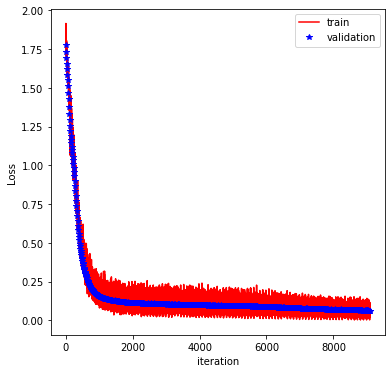

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

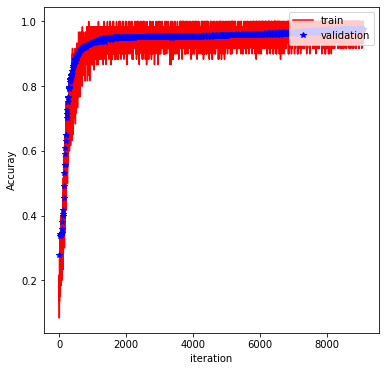

In [17]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [18]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.889796
